In [1]:
from pathlib import Path
from scipy.io import loadmat
import sys
import os

# Robust path finding for data.mat
current_path = Path.cwd()
possible_data_paths = [
    current_path / 'data' / 'data.mat',
    current_path.parent / 'data' / 'data.mat',
    current_path.parent.parent / 'data' / 'data.mat',
    # Fallback absolute path
    Path('/home/luky/skola/KalmanNet-for-state-estimation/data/data.mat')
]

dataset_path = None
for p in possible_data_paths:
    if p.exists():
        dataset_path = p
        break

if dataset_path is None or not dataset_path.exists():
    print("Warning: data.mat not found automatically.")
    dataset_path = Path('data/data.mat')

print(f"Dataset path: {dataset_path}")

# Add project root to sys.path (2 levels up from debug/test)
notebook_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print(f"Project root added: {project_root}")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


Dataset path: /home/luky/skola/KalmanNet-main/data/data.mat
Project root added: /home/luky/skola/KalmanNet-main
dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [2]:
import torch
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
import random

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [3]:
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Dimensions of 1D X axis: {x_axis_unique.shape}")
print(f"Dimensions of 1D Y axis: {y_axis_unique.shape}")
print(f"Dimensions of 2D elevation data Z: {souradniceZ_mapa.shape}")

terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),
    souradniceZ_mapa,
    bounds_error=False, 
    fill_value=np.nan
)

def terMap(px, py):
    # Query bilinear interpolation over the terrain map
    points_to_query = np.column_stack((py, px))
    return terMap_interpolator(points_to_query)

Dimensions of 1D X axis: (2500,)
Dimensions of 1D Y axis: (2500,)
Dimensions of 2D elevation data Z: (2500, 2500)


In [4]:
import torch
from Systems import DynamicSystemTAN

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
# initial_velocity_np = torch.from_numpy()
initial_velocity = torch.from_numpy(np.array([0,0]))

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()
print(x_0)

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])
import torch.nn.functional as func

def h_nl_differentiable(x: torch.Tensor, map_tensor, x_min, x_max, y_min, y_max) -> torch.Tensor:
    batch_size = x.shape[0]

    px = x[:, 0]
    py = x[:, 1]

    px_norm = 2.0 * (px - x_min) / (x_max - x_min) - 1.0
    py_norm = 2.0 * (py - y_min) / (y_max - y_min) - 1.0

    sampling_grid = torch.stack((px_norm, py_norm), dim=1).view(batch_size, 1, 1, 2)

    vyska_terenu_batch = func.grid_sample(
        map_tensor.expand(batch_size, -1, -1, -1),
        sampling_grid, 
        mode='bilinear', 
        padding_mode='border',
        align_corners=True
    )

    vyska_terenu = vyska_terenu_batch.view(batch_size)

    eps = 1e-12
    vx_w, vy_w = x[:, 2], x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=eps)
    cos_psi = vx_w / norm_v_w
    sin_psi = vy_w / norm_v_w

    vx_b = cos_psi * vx_w - sin_psi * vy_w 
    vy_b = sin_psi * vx_w + cos_psi * vy_w

    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)

    return result

x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]
terMap_tensor = torch.from_numpy(souradniceZ_mapa).float().unsqueeze(0).unsqueeze(0).to(device)
x_min, x_max = x_axis_unique.min(), x_axis_unique.max()
y_min, y_max = y_axis_unique.min(), y_axis_unique.max()

h_wrapper = lambda x: h_nl_differentiable(
    x, 
    map_tensor=terMap_tensor, 
    x_min=x_min, 
    x_max=x_max, 
    y_min=y_min, 
    y_max=y_max
)

system_model = DynamicSystemTAN(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_wrapper,
    x_axis_unique=x_axis_unique, 
    y_axis_unique=y_axis_unique,
    device=device
)

tensor([1487547.1250, 6395520.5000,       0.0000,       0.0000])
INFO: DynamicSystemTAN inicializován s hranicemi mapy:
  X: [1476611.42, 1489541.47]
  Y: [6384032.63, 6400441.34]


In [5]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from utils import utils
import torch
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
from copy import deepcopy
from state_NN_models import TAN
from utils import trainer 

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)


In [6]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import os
from utils import trainer # Předpokládám, že toto máš

# === 1. ZJEDNODUŠENÝ DATA MANAGER (BEZ NORMALIZACE) ===
class NavigationDataManager:
    def __init__(self, data_dir):
        """
        Jen držák na cestu k datům. Žádná statistika, žádná normalizace.
        """
        self.data_dir = data_dir
        
    def get_dataloader(self, seq_len, split='train', shuffle=True, batch_size=32):
        # Sestavení cesty: ./generated_data/len_100/train.pt
        path = os.path.join(self.data_dir, f'len_{seq_len}', f'{split}.pt')
        
        if not os.path.exists(path):
            raise FileNotFoundError(f"❌ Dataset nenalezen: {path}")
            
        # Načtení tenzorů
        data = torch.load(path)
        x = data['x'] # Stav [Batch, Seq, DimX]
        y = data['y'] # Měření [Batch, Seq, DimY] - RAW DATA
        
        # Vytvoření datasetu
        dataset = TensorDataset(x, y)
        
        return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# === 2. KONFIGURACE CURRICULA ===
DATA_DIR = './generated_data_clean_motion'

# Inicializace manažera (teď je to jen wrapper pro načítání souborů)
data_manager = NavigationDataManager(DATA_DIR)

# Definice fází (zde řídíš, jak se trénink vyvíjí)
curriculum_schedule = [
    # FÁZE 1: Warm-up (Krátké sekvence)
    {
        'phase_id': 1,
        'seq_len': 10,          
        'epochs': 500,           
        'lr': 1e-3, 
        'batch_size': 256
    },
    
    # FÁZE 2: Stabilizace (Střední délka)
    {
        'phase_id': 2,
        'seq_len': 100, 
        'epochs': 200, 
        'lr': 1e-4,             
        'batch_size': 128
    },
    
    # FÁZE 3: Long-term Reality (Plná délka)
    {
        'phase_id': 3,
        'seq_len': 300,         
        'epochs': 200, 
        'lr': 1e-5,             
        'batch_size': 64       # Menší batch kvůli paměti GPU u dlouhých sekvencí
    }
]

# === 3. NAČÍTÁNÍ DO PAMĚTI (CACHING) ===
print("\n=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===")
datasets_cache = {} 

for phase in curriculum_schedule:
    seq_len = phase['seq_len']
    bs = phase['batch_size']
    
    print(f"📥 Načítám Fázi {phase['phase_id']}: Seq={seq_len} | Batch={bs} ...")
    
    try:
        # Použití DataManageru
        train_loader = data_manager.get_dataloader(seq_len=seq_len, split='train', shuffle=True, batch_size=bs)
        val_loader = data_manager.get_dataloader(seq_len=seq_len, split='val', shuffle=False, batch_size=bs)
        
        # Uložení do cache
        datasets_cache[phase['phase_id']] = (train_loader, val_loader)
        
        # Rychlá kontrola pro jistotu
        x_ex, y_ex = next(iter(train_loader))
        if phase['phase_id'] == 1:
            print(f"   🔎 Ukázka RAW dat (y): {y_ex[0, 0, :].tolist()}") 
            # Měl bys vidět velká čísla (např. 250.0) a malá (0.2), ne ~0.0
        
    except FileNotFoundError as e:
        print(f"   ⚠️ CHYBA: {e}")
        # raise e # Odkomentuj, pokud chceš, aby to spadlo při chybě

print("\n✅ Data připravena. Normalizaci řeší model.")


=== NAČÍTÁNÍ RAW DAT Z DISKU (BEZ EXT. NORMALIZACE) ===
📥 Načítám Fázi 1: Seq=10 | Batch=256 ...
   🔎 Ukázka RAW dat (y): [362.96917724609375, -12.126676559448242, 0.16327548027038574]
📥 Načítám Fázi 2: Seq=100 | Batch=128 ...
📥 Načítám Fázi 3: Seq=300 | Batch=64 ...

✅ Data připravena. Normalizaci řeší model.


In [7]:
import torch
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

def train_BayesianKalmanNet_Hybrid(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad,
    J_samples, validation_period, logging_period,
    warmup_iterations=0, weight_decay_=1e-5,
    lambda_mse=100.0,metric='anees'  # <--- NOVÝ PARAMETR: Kotva pro MSE
):
    # torch.autograd.set_detect_anomaly(True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
    
    # Scheduler: Pokud se loss zasekne, snížíme LR (pomáhá stabilizovat konvergenci)
    # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    #     optimizer, mode='min', factor=0.5, patience=50, verbose=True
    # )

    best_val_anees = float('inf')
    score_at_best = {"val_nll": 0.0, "val_mse": 0.0}
    best_iter_count = 0
    best_model_state = None
    train_iter_count = 0
    done = False

    print(f"🚀 START Hybrid Training: Loss = NLL + {lambda_mse} * MSE")
    print(f"    Logging period: {logging_period} iterations")

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            if torch.isnan(x_true_batch).any():
                print(f"!!! SKIP BATCH iter {train_iter_count}: NaN found in x_true (Ground Truth) !!!")
                continue
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            
            # --- Training ---
            optimizer.zero_grad()
            batch_size, seq_len, _ = x_true_batch.shape
            
            all_trajectories_for_ensemble = []
            all_regs_for_ensemble = []

            # 1. Ensemble Forward Pass
            for j in range(J_samples):
                model.reset(batch_size=batch_size, initial_state=x_true_batch[:, 0, :])
                current_trajectory_x_hats = []
                current_trajectory_regs = []
                for t in range(1, seq_len):
                    y_t = y_meas_batch[:, t, :]
                    x_filtered_t, reg_t = model.step(y_t)
                    if torch.isnan(x_filtered_t).any():
                            raise ValueError(f"NaN in x_filtered_t at sample {j}, step {t}")
                    current_trajectory_x_hats.append(x_filtered_t)
                    current_trajectory_regs.append(reg_t)
                all_trajectories_for_ensemble.append(torch.stack(current_trajectory_x_hats, dim=1))
                all_regs_for_ensemble.append(torch.sum(torch.stack(current_trajectory_regs)))

            # 2. Statistiky Ensemble
            ensemble_trajectories = torch.stack(all_trajectories_for_ensemble, dim=0)
            x_hat_sequence = ensemble_trajectories.mean(dim=0)
            
            # Epistemická variance (čistý rozptyl sítě)
            # Přičítáme 1e-9 jen proti dělení nulou, není to "noise floor"
            cov_diag_sequence = ensemble_trajectories.var(dim=0) + 1e-9 
            
            regularization_loss = torch.stack(all_regs_for_ensemble).mean()
            target_sequence = x_true_batch[:, 1:, :]
            
            # --- 3. VÝPOČET HYBRIDNÍ LOSS ---
            
            # A) MSE Část (Přesnost)
            mse_loss = F.mse_loss(x_hat_sequence, target_sequence)
            
            # B) NLL Část (Konzistence)
            # 0.5 * (log(var) + (target - pred)^2 / var)
            cov_diag_clamped = torch.clamp(cov_diag_sequence, min=1e-4, max=1e6)
            error_sq = (x_hat_sequence - target_sequence) ** 2
            nll_term = 0.5 * (torch.log(cov_diag_clamped) + error_sq / cov_diag_clamped)
            nll_loss = nll_term.mean()
            mean_var = cov_diag_sequence.mean()
            var_penalty = torch.relu(mean_var - 100.0) * 0.01
            
            # C) Celková Loss (Hybrid)
            # Zde je ta magie: I když NLL chce utéct s variancí, lambda_mse * mse ho drží zpátky
            weighted_mse = lambda_mse * mse_loss
            loss = nll_loss + weighted_mse + regularization_loss * 1.0 + var_penalty
            
            if torch.isnan(loss): 
                print("Collapse detected (NaN loss)"); done = True; break
            
            loss.backward()

            # --- DIAGNOSTIC LOGGING (Gradients) ---
            # Zaznamenáme statistiky gradientů před oříznutím (clippingem)
            if train_iter_count % logging_period == 0:
                total_norm = 0.0
                max_grad = 0.0
                min_grad = float('inf')
                nan_grad_detected = False
                for p in model.parameters():
                    if p.grad is not None:
                        param_norm = p.grad.data.norm(2).item()
                        total_norm += param_norm ** 2
                        p_max = p.grad.data.abs().max().item()
                        p_min = p.grad.data.abs().min().item()
                        if p_max > max_grad: max_grad = p_max
                        if p_min < min_grad: min_grad = p_min
                        if torch.isnan(p.grad).any():
                            nan_grad_detected = True
                total_norm = total_norm ** 0.5
                
                if nan_grad_detected:
                     print(f"!!! WARNING: NaN gradient detected at iter {train_iter_count} !!!")

            if clip_grad > 0: torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()
            train_iter_count += 1
            
            # --- Logging ---
            diff = x_hat_sequence - target_sequence
            mean_error = diff.abs().mean().item()
            min_variance = cov_diag_sequence.min().item()
            max_variance = cov_diag_sequence.max().item()
            mean_variance = cov_diag_sequence.mean().item()

            if train_iter_count % logging_period == 0:
                with torch.no_grad():
                    # Zjistíme dropout pravděpodobnosti (jen pro info)
                    p1 = torch.sigmoid(model.dnn.concrete_dropout1.p_logit).item()
                    p2 = torch.sigmoid(model.dnn.concrete_dropout2.p_logit).item()
                
                print(f"--- Iter [{train_iter_count}/{total_train_iter}] ---")
                print(f"    Total Loss:     {loss.item():.4f}")
                print(f"    MSE (Raw):      {mse_loss.item():.6f}")
                print(f"    MSE (Weighted): {weighted_mse.item():.4f} (lambda={lambda_mse})")
                print(f"    NLL Component:  {nll_loss.item():.4f}")
                print(f"    Reg Loss:       {regularization_loss.item():.6f}")
                print(f"    Variance stats: Min={min_variance:.2e}, Max={max_variance:.2e}, Mean={mean_variance:.2e}")
                print(f"    Mean Error L1:  {mean_error:.4f}")
                print(f"    Grad Norm:      {total_norm:.4f} (Max abs grad: {max_grad:.4f})")
                print(f"    Dropout probs:  p1={p1:.4f}, p2={p2:.4f}")
                
                # Check pro "Variance collapse"
                if mean_variance < 1e-8:
                    print("    !!! WARNING: Variance is extremely low (Collapse risk) !!!")

            # --- Validation step ---
            if train_iter_count > 0 and train_iter_count % validation_period == 0:
                # Step scheduleru podle trénovací loss (nebo validace, pokud bys to předělal)
                # scheduler.step(loss)
                
                print(f"\n--- Validation at iteration {train_iter_count} ---")
                model.eval()
                val_mse_list = []
                all_val_x_true_cpu, all_val_x_hat_cpu, all_val_P_hat_cpu = [], [], []

                with torch.no_grad():
                    for x_true_val_batch, y_meas_val_batch in val_loader:
                        val_batch_size, val_seq_len, _ = x_true_val_batch.shape
                        x_true_val_batch = x_true_val_batch.to(device)
                        y_meas_val_batch = y_meas_val_batch.to(device)
                        val_ensemble_trajectories = []
                        for j in range(J_samples):
                            model.reset(batch_size=val_batch_size, initial_state=x_true_val_batch[:, 0, :])
                            val_current_x_hats = []
                            for t in range(1, val_seq_len):
                                y_t_val = y_meas_val_batch[:, t, :]
                                x_filtered_t, _ = model.step(y_t_val)
                                val_current_x_hats.append(x_filtered_t)
                            val_ensemble_trajectories.append(torch.stack(val_current_x_hats, dim=1))
                        
                        # Agregace validace
                        val_ensemble = torch.stack(val_ensemble_trajectories, dim=0)
                        val_preds_seq = val_ensemble.mean(dim=0)
                        
                        val_target_seq = x_true_val_batch[:, 1:, :]
                        val_mse_list.append(F.mse_loss(val_preds_seq, val_target_seq).item())
                        
                        # Příprava pro ANEES
                        initial_state_val = x_true_val_batch[:, 0, :].unsqueeze(1)
                        full_x_hat = torch.cat([initial_state_val, val_preds_seq], dim=1)
                        
                        # Epistemická variance
                        val_covs_diag = val_ensemble.var(dim=0) + 1e-9
                        
                        # Vytvoření diagonálních matic P
                        # (Zjednodušená konstrukce pro ANEES calc)
                        # Pro přesné ANEES bychom měli dělat outer product, 
                        # ale diagonála z var() je dobrá aproximace pro BKN
                        val_covs_full = torch.zeros(val_batch_size, val_seq_len-1, 4, 4, device=device)
                        for b in range(val_batch_size):
                            for t in range(val_seq_len-1):
                                val_covs_full[b, t] = torch.diag(val_covs_diag[b, t])

                        P0 = model.system_model.P0.unsqueeze(0).repeat(val_batch_size, 1, 1).unsqueeze(1)
                        full_P_hat = torch.cat([P0, val_covs_full], dim=1)
                        
                        all_val_x_true_cpu.append(x_true_val_batch.cpu())
                        all_val_x_hat_cpu.append(full_x_hat.cpu())
                        all_val_P_hat_cpu.append(full_P_hat.cpu())

                avg_val_mse = np.mean(val_mse_list)
                final_x_true_list = torch.cat(all_val_x_true_cpu, dim=0)
                final_x_hat_list = torch.cat(all_val_x_hat_cpu, dim=0)
                final_P_hat_list = torch.cat(all_val_P_hat_cpu, dim=0)
                
                # Výpočet ANEES
                try:
                    avg_val_anees = trainer.calculate_anees_vectorized(final_x_true_list, final_x_hat_list, final_P_hat_list)
                except Exception as e:
                    print(f"  !!! Error calculating ANEES: {e}")
                    avg_val_anees = float('nan')
                
                print(f"  Average MSE: {avg_val_mse:.4f}, Average ANEES: {avg_val_anees:.4f}")
                
                # Ukládání modelu:
                if metric=='anees':
                    if not np.isnan(avg_val_anees) and avg_val_anees < best_val_anees and avg_val_anees > 0:
                        print(f"  >>> New best VALIDATION ANEES! Saving model. (Old: {best_val_anees:.4f} -> New: {avg_val_anees:.4f}) <<<")
                        best_val_anees = avg_val_anees
                        best_iter_count = train_iter_count
                        score_at_best['val_mse'] = avg_val_mse
                        best_model_state = deepcopy(model.state_dict())
                else:
                    if avg_val_mse < 200000 and avg_val_mse > 0: # Simple guard
                     best_model_state = deepcopy(model.state_dict())
                print("-" * 50)
                model.train()

    print("\nTraining completed.")
    if best_model_state:
        print(f"Loading best model from iteration {best_iter_count} with ANEES {best_val_anees:.4f}")
        model.load_state_dict(best_model_state)
    else:
        print("No best model was saved; returning last state.")

    return {
        "best_val_anees": best_val_anees,
        "best_val_nll": score_at_best['val_nll'],
        "best_val_mse": score_at_best['val_mse'],
        "best_iter": best_iter_count,
        "final_model": model
    }

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from copy import deepcopy

def train_BayesianKalmanNet_TBPTT(
    model, train_loader, val_loader, device,
    total_train_iter, learning_rate, clip_grad=1.0,
    J_samples=5, tbptt_steps=20, # Délka okna (kroků), po kterých děláme update
    validation_period=50, logging_period=10,
    weight_decay_=1e-5, lambda_mse=1000.0
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay_)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=100, verbose=True
    )

    best_val_anees = float('inf')
    best_model_state = None
    train_iter_count = 0
    done = False

    print(f"🚀 START TBPTT Training (Window={tbptt_steps}): Loss = NLL + {lambda_mse} * MSE")

    while not done:
        model.train()
        for x_true_batch, y_meas_batch in train_loader:
            if train_iter_count >= total_train_iter: done = True; break
            
            x_true_batch = x_true_batch.to(device)
            y_meas_batch = y_meas_batch.to(device)
            
            batch_size, seq_len, dim_x = x_true_batch.shape
            
            # === VEKTORIZOVANÝ ENSEMBLE ===
            # Místo cyklu přes J uděláme "Super Batch": [Batch * J, Seq, Dim]
            # Tím pádem model zpracuje všechny vzorky naráz paralelně.
            x_true_super = x_true_batch.repeat_interleave(J_samples, dim=0)
            y_meas_super = y_meas_batch.repeat_interleave(J_samples, dim=0)
            super_batch_size = x_true_super.shape[0]

            # 1. Reset na začátku sekvence (t=0)
            # Inicializujeme pro všechny vzorky najednou
            model.reset(batch_size=super_batch_size, initial_state=x_true_super[:, 0, :])

            # 2. TBPTT Smyčka přes okna
            # Krájíme sekvenci na kousky délky 'tbptt_steps'
            for t_start in range(1, seq_len, tbptt_steps):
                t_end = min(t_start + tbptt_steps, seq_len)
                current_window_len = t_end - t_start
                if current_window_len <= 0: continue

                optimizer.zero_grad()
                
                # Uložiště pro predikce v okně
                window_x_preds = []
                window_regs = []

                # A) Forward pass oknem
                for t in range(t_start, t_end):
                    y_t = y_meas_super[:, t, :] # [Batch*J, 3]
                    x_est, reg = model.step(y_t)
                    
                    window_x_preds.append(x_est)
                    window_regs.append(reg)
                
                # B) Zpracování výsledků okna
                # Stackneme čas: [Batch*J, Window, 4]
                preds_super = torch.stack(window_x_preds, dim=1)
                regs_super = torch.stack(window_regs) # [Window, Batch*J]
                
                # Rozbalíme zpět na [Batch, J, Window, 4] pro statistiku
                preds_reshaped = preds_super.view(batch_size, J_samples, current_window_len, dim_x)
                
                # Statistiky Ensemble (přes dimenzi J=1)
                x_hat_seq = preds_reshaped.mean(dim=1) # [Batch, Window, 4]
                cov_diag_seq = preds_reshaped.var(dim=1) + 1e-4 # [Batch, Window, 4]
                
                # Ground Truth pro toto okno
                target_seq = x_true_batch[:, t_start:t_end, :]

                # C) Výpočet Loss (pouze pro toto okno!)
                mse_loss = F.mse_loss(x_hat_seq, target_seq)
                
                cov_clamped = torch.clamp(cov_diag_seq, min=1e-4, max=1e6)
                error_sq = (x_hat_seq - target_seq) ** 2
                nll_term = 0.5 * (torch.log(cov_clamped) + error_sq / cov_clamped)
                nll_loss = nll_term.mean()
                
                # Normalizovaná regularizace na okno
                reg_loss = regs_super.mean() / current_window_len 
                
                # Variance penalty (volitelné, proti alibismu)
                var_penalty = torch.relu(cov_diag_seq.mean() - 100.0) * 0.01

                loss = nll_loss + (lambda_mse * mse_loss) + reg_loss + var_penalty
                
                # D) Backward & Update
                loss.backward()
                if clip_grad > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
                optimizer.step()
                
                # E) !!! DETACH HIDDEN STATE !!!
                # Toto je podstata TBPTT. Utneme gradienty, ale necháme hodnoty stavů
                # pro další okno.
                model.detach_hidden()
                
                train_iter_count += 1 # Počítáme každý update (okno) jako iteraci

                # --- Logging (uvnitř okna, aby to bylo časté) ---
                if train_iter_count % logging_period == 0:
                    print(f"Iter {train_iter_count} (TBPTT): Loss {loss.item():.4f} | MSE {mse_loss.item():.2f} | VarMean {cov_diag_seq.mean().item():.1f}")

            # --- Validation step (Na konci batchi, ne okna) ---
            if train_iter_count % validation_period == 0:  # Zjednodušená podmínka
                model.eval()
                val_mse_list = []
                # Pro validaci musíme bohužel iterovat po staru nebo taky vektorizovaně
                # Zde zjednodušeně celou sekvenci naráz (bez TBPTT, jen inference)
                with torch.no_grad():
                    for x_val, y_val in val_loader:
                        x_val, y_val = x_val.to(device), y_val.to(device)
                        b_val, s_val, _ = x_val.shape
                        
                        # Vektorizovaný validace
                        x_val_super = x_val.repeat_interleave(J_samples, dim=0)
                        y_val_super = y_val.repeat_interleave(J_samples, dim=0)
                        
                        model.reset(batch_size=b_val*J_samples, initial_state=x_val_super[:,0,:])
                        preds = []
                        for t in range(1, s_val):
                            est, _ = model.step(y_val_super[:, t, :])
                            preds.append(est)
                        
                        preds_stack = torch.stack(preds, dim=1).view(b_val, J_samples, s_val-1, 4)
                        mean_preds = preds_stack.mean(dim=1)
                        val_mse_list.append(F.mse_loss(mean_preds, x_val[:, 1:, :]).item())
                
                avg_val_mse = np.mean(val_mse_list)
                print(f"\n--- VALIDATION: MSE {avg_val_mse:.4f} ---")
                
                if avg_val_mse < 200000 and avg_val_mse > 0: # Simple guard
                     best_model_state = deepcopy(model.state_dict())
                
                model.train()

    print("TBPTT Training completed.")
    if best_model_state:
        model.load_state_dict(best_model_state)
    return {"final_model": model}

In [9]:
import torch
import copy

# Předpokládám, že funkce train_BayesianKalmanNet_TBPTT je definována (z předchozího kroku)
# from utils import train_BayesianKalmanNet_TBPTT  <-- pokud ji máte v souboru

# --- 1. DEFINICE CURRICULA ---
curriculum_schedule = [
    # FÁZE 1: Stabilizace (Krátké sekvence - stačí standardní trénink)
    {
        'phase_id': 1,
        'seq_len': 10,
        'iters': 400,
        'lr': 1e-3,
        'lambda_mse': 1000.0,
        'clip_grad': 1.0,
        'use_tbptt': False,   # Tady TBPTT nepotřebujeme
        'tbptt_steps': None
    },
    # FÁZE 2: Prodloužení (Střední sekvence - ZAPÍNÁME TBPTT)
    # TBPTT nám umožní trénovat na délce 100, aniž by explodovala variance
    {
        'phase_id': 2,
        'seq_len': 100,
        'iters': 1000,        # Více iterací, protože TBPTT dělá menší kroky
        'lr': 1e-5,           # Opatrné učení
        'lambda_mse': 1000.0, # Stále držíme prioritu na přesnost
        'clip_grad': 0.25,
        'use_tbptt': False,    # <--- ZAPNUTO
        'tbptt_steps': 10     # Učíme se na oknech délky 20
    },
    # {
    #     'phase_id': 3,
    #     'seq_len': 300,
    #     'iters': 1000,        # Více iterací, protože TBPTT dělá menší kroky
    #     'lr': 1e-6,           # Opatrné učení
    #     'lambda_mse': 100.0, # Stále držíme prioritu na přesnost
    #     'clip_grad': 0.01,
    #     'use_tbptt': False,    # <--- ZAPNUTO
    #     'tbptt_steps': 50     # Učíme se na oknech délky 20
    # }
]

# --- 2. INICIALIZACE MODELU ---
print("=== INICIALIZACE BKN MODELU ===")
# Používáme váš osvědčený setup s vyšším hidden size
state_knet2 = TAN.StateBayesianKalmanNetTAN(
        system_model=system_model, 
        device=device,
        hidden_size_multiplier=6,       
        output_layer_multiplier=4,
        num_gru_layers=1,
        init_max_dropout=0.3, # Zdravý dropout pro exploration
        init_min_dropout=0.1    
).to(device)

# --- 3. CURRICULUM LOOP ---
for phase in curriculum_schedule:
    phase_id = phase['phase_id']
    seq_len = phase['seq_len']

    # Kontrola dostupnosti dat
    if phase_id not in datasets_cache:
        print(f"⚠️ Skipping Phase {phase_id}: Data not in cache.")
        continue

    print(f"\n" + "="*60)
    print(f"🚀 START PHASE {phase_id}: SeqLen {seq_len} | LR {phase['lr']} | TBPTT: {phase['use_tbptt']}")
    print("="*60)
    
    train_loader_phase = datasets_cache[phase_id][0]
    val_loader_phase = datasets_cache[phase_id][1]
    
    # Rozhodování podle typu tréninku
    if phase['use_tbptt']:
        # === A) TBPTT Trénink (pro dlouhé sekvence) ===
        print(f"   -> Using TBPTT with window size {phase['tbptt_steps']}")
        
        # Zkontrolujeme, zda model má metodu detach_hidden (prevence pádu)
        if not hasattr(state_knet2, 'detach_hidden'):
            raise AttributeError("Modelu chybí metoda 'detach_hidden()'! Přidejte ji do třídy StateBayesianKalmanNetTAN.")

        result = train_BayesianKalmanNet_TBPTT(
            model=state_knet2,
            train_loader=train_loader_phase,
            val_loader=val_loader_phase,
            device=device,
            total_train_iter=phase['iters'],
            learning_rate=phase['lr'],
            clip_grad=phase['clip_grad'],
            J_samples=10,               # V TBPTT můžeme mít menší J, protože se průměruje častěji
            tbptt_steps=phase['tbptt_steps'],
            validation_period=50,       # Validace každých 50 oken
            logging_period=10,
            lambda_mse=phase['lambda_mse']
        )
        
    else:
        # === B) Standardní Hybrid Trénink (pro krátké sekvence) ===
        print(f"   -> Using Standard Hybrid Training")
        result = train_BayesianKalmanNet_Hybrid(
            model=state_knet2,
            train_loader=train_loader_phase,
            val_loader=val_loader_phase,
            device=device,
            total_train_iter=phase['iters'],
            learning_rate=phase['lr'],
            clip_grad=phase['clip_grad'],
            J_samples=5,
            validation_period=5,
            logging_period=10,
            warmup_iterations=0,
            weight_decay_=1e-4,
            lambda_mse=phase['lambda_mse'],
            metric='mse'
        )
    
    # Uložení a kontrola
    save_path = f"bkn_curriculum_phase{phase_id}_len{seq_len}.pth"
    torch.save(state_knet2.state_dict(), save_path)
    print(f"✅ Fáze {phase_id} dokončena. Model uložen do: {save_path}")
    
    # Jednoduchá kontrola proti divergenci (pokud best_val neexistuje nebo je inf)
    # Pozn: TBPTT funkce vrací slovník, hybrid taky, ujistíme se, že klíče sedí
    # TBPTT momentálně vrací jen {'final_model': model}, pro pokročilou kontrolu by to chtělo vrátit i loss.
    # Ale pro teď to necháme běžet dál.

print("\n🎉 Celý trénink dokončen.")

=== INICIALIZACE BKN MODELU ===
INFO: Aplikuji upravenou inicializaci pro BKN.
DEBUG: Výstupní vrstva inicializována konzervativně (interval -0.1 až 0.1).

🚀 START PHASE 1: SeqLen 10 | LR 0.001 | TBPTT: False
   -> Using Standard Hybrid Training
🚀 START Hybrid Training: Loss = NLL + 1000.0 * MSE
    Logging period: 10 iterations

--- Validation at iteration 5 ---
  Average MSE: 209.0129, Average ANEES: 54.2269
--------------------------------------------------
--- Iter [10/400] ---
    Total Loss:     99859.0234
    MSE (Raw):      99.848488
    MSE (Weighted): 99848.4844 (lambda=1000.0)
    NLL Component:  10.5296
    Reg Loss:       0.008980
    Variance stats: Min=1.00e-09, Max=4.92e+03, Mean=2.81e+01
    Mean Error L1:  5.1643
    Grad Norm:      5595636.1010 (Max abs grad: 1165905.3750)
    Dropout probs:  p1=0.2824, p2=0.1212

--- Validation at iteration 10 ---
  Average MSE: 57.7581, Average ANEES: 35.8050
--------------------------------------------------

--- Validation at ite

KeyboardInterrupt: 

In [ ]:
if False:
    # save model.
    save_path = f'most_consistent_and_accurate_bknet.pth'
    torch.save(state_knet2.state_dict(), save_path)
    print(f"Model saved to '{save_path}'.")

# Test na realne trajektorii

=== SPUŠTĚNÍ MONTE CARLO SIMULACE (2 běhů) ===
Modely: BKN (J=100) vs. UKF vs. PF


Simulace:   0%|          | 0/2 [00:00<?, ?it/s]

Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varová

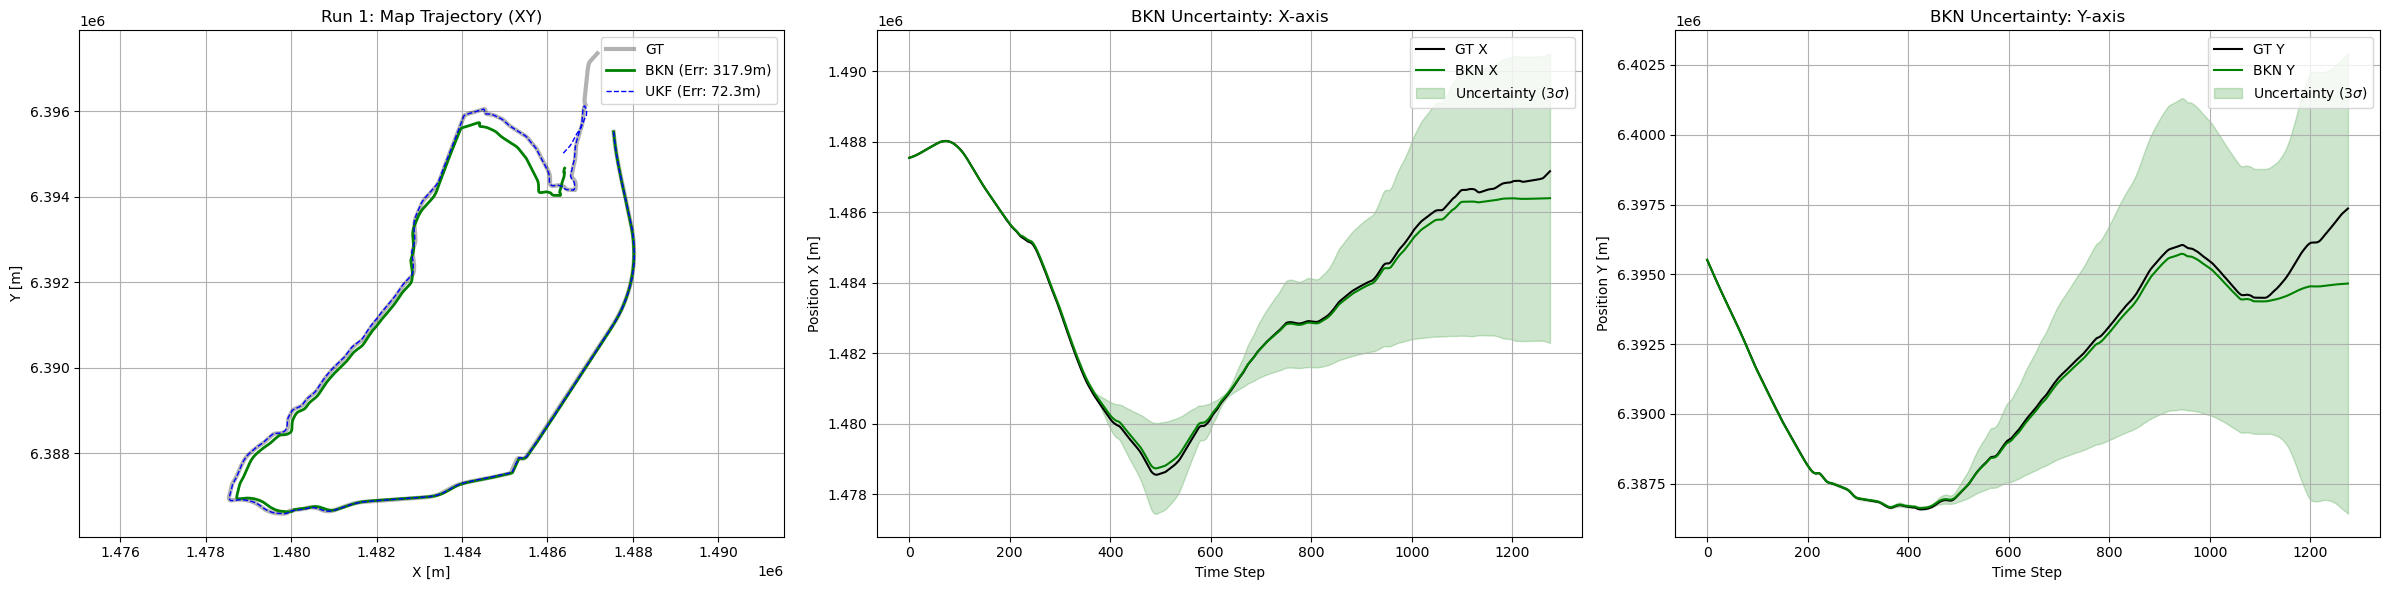

Simulace:  50%|█████     | 1/2 [03:41<03:41, 221.52s/it]

Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varování: Součet vah je téměř nulový. Resetuji na uniformní rozdělení.
Varová

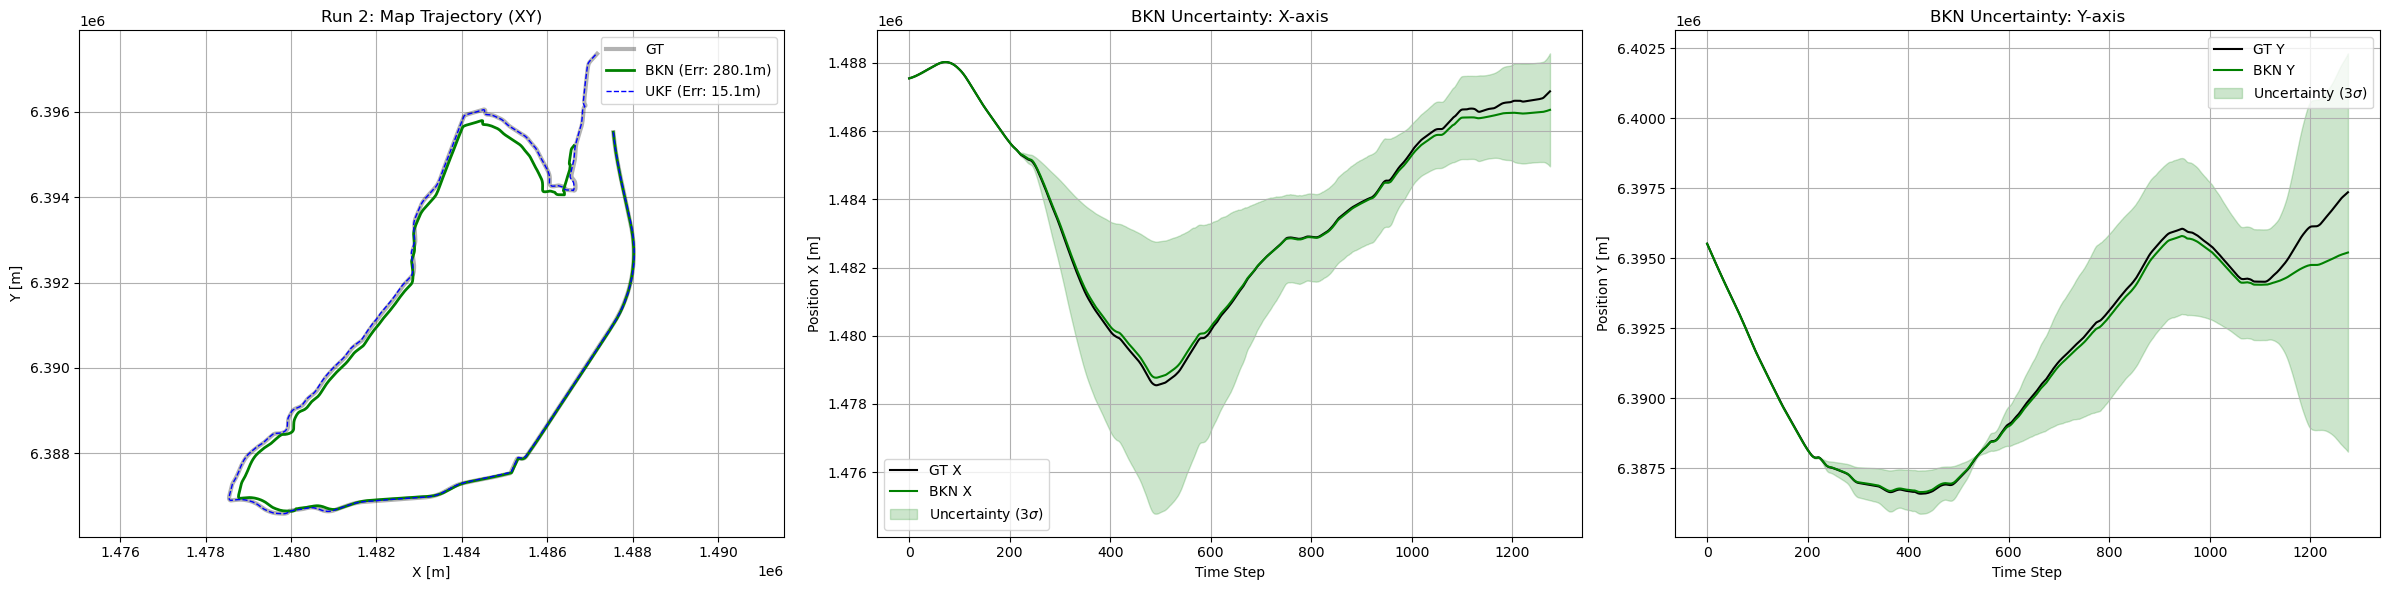

Simulace: 100%|██████████| 2/2 [07:20<00:00, 220.30s/it]


SOUHRNNÁ STATISTIKA (2 běhů)
Model           | MSE                       | Pos Error                
---------------------------------------------------------------------------
BKN (Ensemble)  | 77865.3 ± 13877.9 | 299.02 ± 18.93 m
UKF             | 12238.7 ± 12164.5 | 43.72 ± 28.59 m
PF              | 282103.1 ± 280467.2 | 293.32 ± 221.73 m


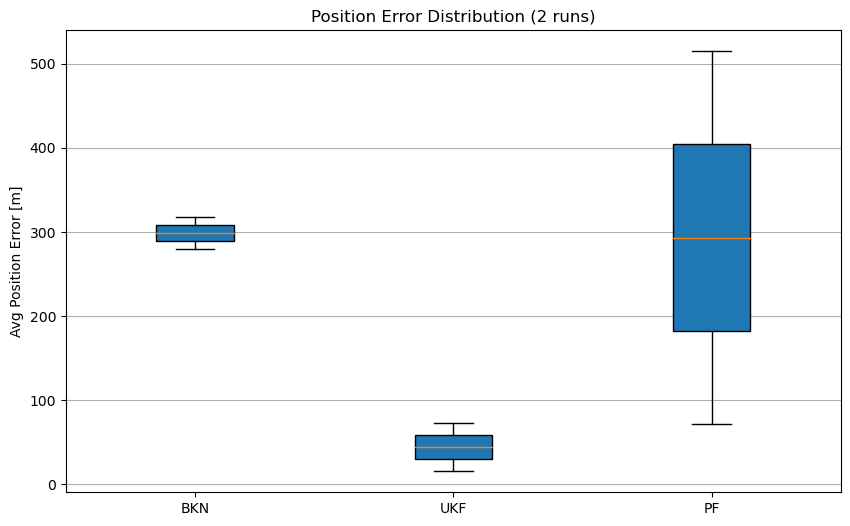

In [10]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import Filters
import torch.nn.functional as F
from tqdm import tqdm

# === KONFIGURACE MC ===
MC_ITERATIONS = 2  
J_SAMPLES = 100      
PLOT_PER_ITERATION = True  # True = vykreslí grafy (první a poslední běh), False = žádné grafy

# Příprava dat
real_traj_np = souradniceGNSS[:2, :].T 
real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)

# --- POMOCNÁ FUNKCE ---
def get_reference_test_set(system, real_traj_tensor):
    device = system.Ex0.device
    hB_np = mat_data['hB']
    real_hB_tensor = torch.from_numpy(hB_np).float().to(device).view(-1)

    pos_full = real_traj_tensor.clone().to(device)
    deltas = pos_full[1:] - pos_full[:-1] 
    last_vel = deltas[-1:]
    velocities = torch.cat([deltas, last_vel], dim=0) 
    
    x_traj_flat = torch.cat([pos_full, velocities], dim=1) 
    y_traj_flat = system.measure(x_traj_flat) 
    
    seq_len = x_traj_flat.shape[0]
    y_traj_flat[:, 0] = real_hB_tensor[:seq_len] 
    
    x_ref = x_traj_flat.unsqueeze(0) 
    y_ref = y_traj_flat.unsqueeze(0) 
    
    return x_ref, y_ref

print(f"=== SPUŠTĚNÍ MONTE CARLO SIMULACE ({MC_ITERATIONS} běhů) ===")
print(f"Modely: BKN (J={J_SAMPLES}) vs. UKF vs. PF")

# 1. Příprava Ground Truth
x_ref_tensor_static, _ = get_reference_test_set(system_model, real_traj_tensor)
x_gt = x_ref_tensor_static.squeeze().cpu().numpy()
seq_len = x_gt.shape[0]

# 2. Inicializace metrik
detailed_results = []
agg_metrics = {
    "BKN": {"mse": [], "pos": []}, 
    "UKF": {"mse": [], "pos": []}, 
    "PF":  {"mse": [], "pos": []}
}

state_knet2.train() 

# --- HLAVNÍ SMYČKA ---
for i in tqdm(range(MC_ITERATIONS), desc="Simulace"):
    
    # A) Nové měření (náhodný šum)
    _, y_ref_tensor = get_reference_test_set(system_model, real_traj_tensor)
    y_meas = y_ref_tensor 
    
    # B) Inference: BKN Ensemble
    with torch.no_grad():
        initial_state = x_ref_tensor_static[:, 0, :] 
        ensemble_preds = []
        
        for j in range(J_SAMPLES):
            state_knet2.reset(batch_size=1, initial_state=initial_state)
            trajectory_preds = []
            for t in range(1, seq_len):
                y_t = y_meas[:, t, :]
                x_est, _ = state_knet2.step(y_t)
                trajectory_preds.append(x_est)
            
            trajectory_tensor = torch.stack(trajectory_preds, dim=1) 
            full_traj = torch.cat([initial_state.unsqueeze(1), trajectory_tensor], dim=1)
            ensemble_preds.append(full_traj)
            
        ensemble_stack = torch.stack(ensemble_preds, dim=0) 
        x_est_bkn_tensor = ensemble_stack.mean(dim=0).squeeze(0) 
        cov_diag_bkn = ensemble_stack.var(dim=0).squeeze(0) + 1e-9 
        
        x_est_bkn = x_est_bkn_tensor.cpu().numpy()
        std_bkn = torch.sqrt(cov_diag_bkn).cpu().numpy() 

    # C) Inference: UKF & PF
    y_for_filters = y_ref_tensor.squeeze(0) 
    true_init_state = x_ref_tensor_static[0, 0, :] 
    
    # UKF
    ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
    ukf_res = ukf_ideal.process_sequence(y_seq=y_for_filters, Ex0=true_init_state, P0=system_model.P0)
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()

    # PF
    pf = Filters.ParticleFilter(system_model, num_particles=5000) 
    pf_res = pf.process_sequence(y_seq=y_for_filters, Ex0=true_init_state, P0=system_model.P0)
    x_est_pf = pf_res['x_filtered'].cpu().numpy()

    # D) Výpočet chyb
    def calc_errors(x_est, x_gt):
        diff = x_est - x_gt
        mse = np.mean(diff**2)
        pos_err = np.mean(np.sqrt(diff[:, 0]**2 + diff[:, 1]**2))
        return mse, pos_err

    mse_bkn, pos_bkn = calc_errors(x_est_bkn, x_gt)
    mse_ukf, pos_ukf = calc_errors(x_est_ukf, x_gt)
    mse_pf, pos_pf = calc_errors(x_est_pf, x_gt)
    
    agg_metrics["BKN"]["mse"].append(mse_bkn); agg_metrics["BKN"]["pos"].append(pos_bkn)
    agg_metrics["UKF"]["mse"].append(mse_ukf); agg_metrics["UKF"]["pos"].append(pos_ukf)
    agg_metrics["PF"]["mse"].append(mse_pf);   agg_metrics["PF"]["pos"].append(pos_pf)

    detailed_results.append({
        "Run_ID": i + 1,
        "BKN_MSE": mse_bkn, "UKF_MSE": mse_ukf, "PF_MSE": mse_pf,
        "BKN_Pos": pos_bkn, "UKF_Pos": pos_ukf, "PF_Pos": pos_pf
    })
    
    # E) VYKRESLENÍ (Upraveno pro X i Y s neurčitostí)
    # Vykreslíme jen první a poslední běh, abychom nezahltili výstup, pokud je PLOT_PER_ITERATION True
    if PLOT_PER_ITERATION and (i == 0 or i == MC_ITERATIONS-1):
        fig, ax = plt.subplots(1, 3, figsize=(24, 6)) # 3 grafy vedle sebe
        
        # 1. Graf: Trajektorie v mapě (XY)
        ax[0].plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='GT')
        ax[0].plot(x_est_bkn[:, 0], x_est_bkn[:, 1], 'g-', linewidth=2, label=f'BKN (Err: {pos_bkn:.1f}m)')
        ax[0].plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (Err: {pos_ukf:.1f}m)')
        ax[0].set_title(f"Run {i+1}: Map Trajectory (XY)")
        ax[0].set_xlabel("X [m]")
        ax[0].set_ylabel("Y [m]")
        ax[0].legend()
        ax[0].grid(True)
        ax[0].axis('equal')
        
        # Společná časová osa
        time_steps = np.arange(seq_len)

        # 2. Graf: Vývoj X v čase s neurčitostí
        ax[1].plot(time_steps, x_gt[:, 0], 'k-', label='GT X')
        ax[1].plot(time_steps, x_est_bkn[:, 0], 'g-', label='BKN X')
        # Pásmo neurčitosti X (+/- 3 sigma)
        ax[1].fill_between(time_steps, 
                           x_est_bkn[:, 0] - 3*std_bkn[:, 0], 
                           x_est_bkn[:, 0] + 3*std_bkn[:, 0], 
                           color='green', alpha=0.2, label='Uncertainty (3$\sigma$)')
        ax[1].set_title("BKN Uncertainty: X-axis")
        ax[1].set_ylabel("Position X [m]")
        ax[1].set_xlabel("Time Step")
        ax[1].legend()
        ax[1].grid(True)

        # 3. Graf: Vývoj Y v čase s neurčitostí
        ax[2].plot(time_steps, x_gt[:, 1], 'k-', label='GT Y')
        ax[2].plot(time_steps, x_est_bkn[:, 1], 'g-', label='BKN Y')
        # Pásmo neurčitosti Y (+/- 3 sigma)
        ax[2].fill_between(time_steps, 
                           x_est_bkn[:, 1] - 3*std_bkn[:, 1], 
                           x_est_bkn[:, 1] + 3*std_bkn[:, 1], 
                           color='green', alpha=0.2, label='Uncertainty (3$\sigma$)')
        ax[2].set_title("BKN Uncertainty: Y-axis")
        ax[2].set_ylabel("Position Y [m]")
        ax[2].set_xlabel("Time Step")
        ax[2].legend()
        ax[2].grid(True)

        plt.tight_layout()
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*80)
print(f"SOUHRNNÁ STATISTIKA ({MC_ITERATIONS} běhů)")
print("="*80)

def get_stats_str(key):
    m_mse, s_mse = np.mean(agg_metrics[key]["mse"]), np.std(agg_metrics[key]["mse"])
    m_pos, s_pos = np.mean(agg_metrics[key]["pos"]), np.std(agg_metrics[key]["pos"])
    return f"{m_mse:.1f} ± {s_mse:.1f} | {m_pos:.2f} ± {s_pos:.2f} m"

print(f"{'Model':<15} | {'MSE':<25} | {'Pos Error':<25}")
print("-" * 75)
print(f"{'BKN (Ensemble)':<15} | {get_stats_str('BKN')}")
print(f"{'UKF':<15} | {get_stats_str('UKF')}")
print(f"{'PF':<15} | {get_stats_str('PF')}")
print("="*80)

# Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([agg_metrics["BKN"]["pos"], agg_metrics["UKF"]["pos"], agg_metrics["PF"]["pos"]], 
            labels=['BKN', 'UKF', 'PF'], patch_artist=True)
plt.title(f"Position Error Distribution ({MC_ITERATIONS} runs)")
plt.ylabel("Avg Position Error [m]")
plt.grid(True, axis='y')
plt.show()

# Test na synteticke trajektorii

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Pro hezkou tabulku
import Filters
from tqdm import tqdm
real_traj_np = souradniceGNSS[:2, :].T 

real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)
train_source_tensor = real_traj_tensor[:, :]
# --- POMOCNÁ FUNKCE PRO GENEROWÁNÍ DAT ---
def get_reference_test_set(system, real_traj_tensor, reverse=False):
    # Oříznutí trajektorie (pokud je potřeba)
    # real_traj_tensor = real_traj_tensor[:1050,:] 
    
    device = system.Ex0.device
    
    # Předpoklad: mat_data je globální proměnná s načteným .mat souborem
    # hB_np = mat_data['hB']
    # real_hB_tensor = torch.from_numpy(hB_np).float().to(device).view(-1)

    pos_full = real_traj_tensor.clone().to(device)
    
    deltas = pos_full[1:] - pos_full[:-1] 
    last_vel = deltas[-1:]
    velocities = torch.cat([deltas, last_vel], dim=0) # [T, 2]
    
    x_traj_flat = torch.cat([pos_full, velocities], dim=1) # [T, 4]
    
    # Generování měření (s náhodným šumem uvnitř system.measure)
    y_traj_flat = system.measure(x_traj_flat) # [T, 3]
    
    # Nahrazení barometru reálnými daty (pokud je to žádoucí)
    seq_len = x_traj_flat.shape[0]
    # Pokud chceš simulovat čistě syntetický šum barometru, tento řádek zakomentuj:
    # y_traj_flat[:, 0] = real_hB_tensor[:seq_len] 
    
    x_ref = x_traj_flat.unsqueeze(0) # [1, T, 4]
    y_ref = y_traj_flat.unsqueeze(0) # [1, T, 3]
    
    return x_ref, y_ref


# --- KONFIGURACE MC ---
MC_ITERATIONS = 10  # Nastav rozumné číslo (pro 100 grafů by to zahltilo notebook)
PLOT_PER_ITERATION = True # Zda vykreslovat grafy pro každý běh

print(f"=== SPUŠTĚNÍ MONTE CARLO SIMULACE ({MC_ITERATIONS} běhů) ===")
print("Modely: KalmanNet vs. UKF vs. PF")

# 1. Příprava Ground Truth (GT)
real_traj_tensor = torch.from_numpy(real_traj_np).float().to(device)
# Získáme GT stavy (X) jen jednou, protože trajektorie je fixní
# Měření (Y) se bude měnit v každé iteraci kvůli šumu
x_ref_tensor_static, _ = get_reference_test_set(system_model, real_traj_tensor)
x_gt = x_ref_tensor_static.squeeze().cpu().numpy()
seq_len = x_gt.shape[0]

# 2. Inicializace pro sběr dat
detailed_results = [] # Seznam slovníků pro DataFrame
agg_mse = {"KNet": [], "UKF": [], "PF": []}
agg_pos = {"KNet": [], "UKF": [], "PF": []}

# Ujistíme se, že KNet je v eval módu
state_knet2.eval()

# --- HLAVNÍ SMYČKA ---
for i in tqdm(range(MC_ITERATIONS), desc="Simulace"):
    
    # A) Generování nového měření (s novým náhodným šumem)
    # Voláme funkci znovu, abychom dostali Y s jinou realizací šumu (pokud system.measure šumí)
    _, y_ref_tensor = get_reference_test_set(system_model, real_traj_tensor)
    
    # B) Inference: KalmanNet
    with torch.no_grad():
        initial_state = x_ref_tensor_static[:, 0, :] # [1, 4]
        state_knet2.reset(batch_size=1, initial_state=initial_state)
        
        knet_preds = []
        y_input = y_ref_tensor 
        
        for t in range(1, seq_len):
            y_t = y_input[:, t, :]
            x_est = state_knet2.step(y_t)
            knet_preds.append(x_est)
            
        knet_preds_tensor = torch.stack(knet_preds, dim=1)
        full_knet_est = torch.cat([initial_state.unsqueeze(1), knet_preds_tensor], dim=1)
        x_est_knet = full_knet_est.squeeze().cpu().numpy()

    # C) Inference: UKF & PF
    y_for_filters = y_ref_tensor.squeeze(0) 
    
    # !!! KLÍČOVÁ OPRAVA: Použijeme SKUTEČNÝ startovní bod trajektorie !!!
    true_init_state = x_ref_tensor_static[0, 0, :] 
    
    # UKF
    ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
    ukf_res = ukf_ideal.process_sequence(
        y_seq=y_for_filters,
        Ex0=true_init_state, # Správný start
        P0=system_model.P0
    )
    x_est_ukf = ukf_res['x_filtered'].cpu().numpy()

    # PF
    pf = Filters.ParticleFilter(system_model, num_particles=10000) # Počet částic dle výkonu
    pf_res = pf.process_sequence(
        y_seq=y_for_filters,
        Ex0=true_init_state, # Správný start
        P0=system_model.P0
    )
    x_est_pf = pf_res['x_filtered'].cpu().numpy()

    
    # D) Výpočet chyb pro tento běh
    # KNet
    diff_knet = x_est_knet - x_gt
    mse_knet = np.mean(diff_knet**2)
    pos_err_knet = np.mean(np.sqrt(diff_knet[:, 0]**2 + diff_knet[:, 1]**2))
    
    # UKF
    diff_ukf = x_est_ukf - x_gt
    mse_ukf = np.mean(diff_ukf**2)
    pos_err_ukf = np.mean(np.sqrt(diff_ukf[:, 0]**2 + diff_ukf[:, 1]**2))
    
    # PF
    diff_pf = x_est_pf - x_gt
    mse_pf = np.mean(diff_pf**2)
    pos_err_pf = np.mean(np.sqrt(diff_pf[:, 0]**2 + diff_pf[:, 1]**2))
    
    # Uložení do agregátoru
    agg_mse["KNet"].append(mse_knet)
    agg_pos["KNet"].append(pos_err_knet)
    agg_mse["UKF"].append(mse_ukf)
    agg_pos["UKF"].append(pos_err_ukf)
    agg_mse["PF"].append(mse_pf)
    agg_pos["PF"].append(pos_err_pf)

    # Uložení do detailního seznamu
    detailed_results.append({
        "Run_ID": i + 1,
        "KNet_MSE": mse_knet,
        "UKF_MSE": mse_ukf,
        "PF_MSE": mse_pf,
        "KNet_PosErr": pos_err_knet,
        "UKF_PosErr": pos_err_ukf,
        "PF_PosErr": pos_err_pf
    })
    
    # E) Vykreslení grafu pro TENTO běh
    if PLOT_PER_ITERATION:
        fig = plt.figure(figsize=(12, 6))
        plt.plot(x_gt[:, 0], x_gt[:, 1], 'k-', linewidth=3, alpha=0.3, label='Ground Truth')
        
        plt.plot(x_est_knet[:, 0], x_est_knet[:, 1], 'g-', linewidth=1.5, label=f'KalmanNet (MSE: {mse_knet:.1f})')
        plt.plot(x_est_ukf[:, 0], x_est_ukf[:, 1], 'b--', linewidth=1, label=f'UKF (MSE: {mse_ukf:.1f})')
        plt.plot(x_est_pf[:, 0], x_est_pf[:, 1], 'r:', linewidth=1, alpha=0.8, label=f'PF (MSE: {mse_pf:.1f})')
        
        plt.title(f"Run {i+1}/{MC_ITERATIONS}: Trajectory Comparison")
        plt.xlabel("X [m]")
        plt.ylabel("Y [m]")
        plt.legend()
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# --- VÝPIS VÝSLEDKŮ ---

# 1. Detailní tabulka všech běhů
df_results = pd.DataFrame(detailed_results)
print("\n" + "="*80)
print(f"DETAILNÍ VÝSLEDKY PO JEDNOTLIVÝCH BĚZÍCH")
print("="*80)
# Formátování tabulky pro hezčí výpis
pd.options.display.float_format = '{:,.2f}'.format
print(df_results[["Run_ID", "KNet_MSE", "UKF_MSE", "PF_MSE", "KNet_PosErr", "UKF_PosErr", "PF_PosErr"]])

# 2. Souhrnná statistika
print("\n" + "="*80)
print(f"SOUHRNNÁ STATISTIKA ({MC_ITERATIONS} běhů)")
print("="*80)

def get_stats(key):
    return np.mean(agg_mse[key]), np.std(agg_mse[key]), np.mean(agg_pos[key]), np.std(agg_pos[key])

knet_stats = get_stats("KNet")
ukf_stats = get_stats("UKF")
pf_stats = get_stats("PF")

print(f"{'Model':<15} | {'MSE (Mean ± Std)':<25} | {'Pos Error (Mean ± Std)':<25}")
print("-" * 75)
print(f"{'KalmanNet':<15} | {knet_stats[0]:.1f} ± {knet_stats[1]:.1f} | {knet_stats[2]:.2f} ± {knet_stats[3]:.2f} m")
print(f"{'UKF':<15} | {ukf_stats[0]:.1f} ± {ukf_stats[1]:.1f} | {ukf_stats[2]:.2f} ± {ukf_stats[3]:.2f} m")
print(f"{'PF':<15} | {pf_stats[0]:.1f} ± {pf_stats[1]:.1f} | {pf_stats[2]:.2f} ± {pf_stats[3]:.2f} m")
print("="*80)

# 3. Finální Boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([agg_pos["KNet"], agg_pos["UKF"], agg_pos["PF"]], labels=['KalmanNet', 'UKF', 'PF'], patch_artist=True)
plt.title(f"Position Error Distribution ({MC_ITERATIONS} runs)")
plt.ylabel("Avg Position Error [m]")
plt.grid(True, axis='y')
plt.show()